### Verify that pytorch-geometric is correctly installed

If the notebook crashes at the import, there is likely an issue with the version of torch_geometric and torch_sparse being incompatible with the torch version.

In [1]:
## Verify that pytorch-geometric is correctly installed
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing
import numpy as np

## Load model
This steps takes a few minutes for the model to download.

**UPDATE**: It is important to set the model in eval mode through `model = model.eval()` to disable random dropout for optimal performance.

In [2]:
import esm
model, alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
model = model.eval()
model = model.to('cuda')
#google how to transfer model onto gpu
#something like model = model.to('cuda')

/home/gkannan/anaconda3/envs/inverse-test/lib/python3.9/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [3]:
!nvidia-smi

Sat Sep  3 18:56:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:01:00.0 Off |                    0 |
|  0%   34C    P0    50W / 300W |   1235MiB / 45634MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          On   | 00000000:43:00.0 Off |                    0 |
|  0%   

## Load structure from PDB or CIF files


In [4]:
!wget https://files.rcsb.org/download/6VXX.pdb -P data/    # save this to the data folder in colab

--2022-09-03 18:56:25--  https://files.rcsb.org/download/6VXX.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.234
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘data/6VXX.pdb.4’

6VXX.pdb.4              [ <=>                ]   2.07M  --.-KB/s    in 0.09s   

2022-09-03 18:56:26 (24.2 MB/s) - ‘data/6VXX.pdb.4’ saved [2175579]



Load chain from PDB file:

In [5]:
fpath = 'data/6M0J.pdb' # .pdb format is also acceptable
chain_id = 'E'
structure = esm.inverse_folding.util.load_structure(fpath, chain_id)
coords, native_seq = esm.inverse_folding.util.extract_coords_from_structure(structure)
print('Native sequence:')
print(native_seq)
print(len(native_seq))

Native sequence:
TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG
194


## Calculate all possible mutations in a protein

To do this, we define the 'template' sequence - the full sequence of what we want to analyze. For example, this can be the SARS-CoV-2 spike. Then, we define the 'mutating' sequence - the section of that that we want to mutate. This could be the RBD. If both are the same, we mutate and analyze the full RBD.

In [6]:
#Calculating all possible mutants in protein

#RBD:
wuhan = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
alpha = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'
delta = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'
beta = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'

wt_6vxx_spike = 'AYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVNCTFEYVSFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKGNYNYLYRKPFERDIYFPLQSYGFQPTNVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTSQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDPPEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDS'
wt_6vxx_ntd = 'AYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVNCTFEYVSFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQT'

## Why am I not using the full RBD/spike/etc.? The model won't allow me - it only takes into account lengths if they match the native sequence in the pdb.


chosenseq = delta  #The template sequence - i.e. if you want to run full spike but mutate RBD, this is full spike.
chosenseqname = 'delta'  
choosemutseq = delta   #The sequence you want to mutate - for example, RBD in full spike
startpoint = 0   #The AA residue (indexed at 0) that the mutated sequence starts at in template.
true_index = 333 #The true start of the sequence in the FL spike protein; for RBD this is 333, for NTD this is 14


seq = list(chosenseq)
aalist = ["A","R","N","D","C","E","Q","G","H","I","L","K","M","F","P","S","T","W","Y","V"]

seq2 = seq.copy()
muts = {'WT': "".join(seq)}

for i in range(startpoint,startpoint+len(choosemutseq)):
  for j in aalist:
    seq2[i] = j
    muts.update({str(i)+j:"".join(seq2)})
    seq2 = seq.copy()


In [7]:
#Saving in /data folder

output_path = 'data/all_mutant_list_'+chosenseqname+'.txt'
output_file = open(output_path,'w')

for seq_id, sequence in muts.items():
    identifier_line = ">" + seq_id + "\n"
    output_file.write(identifier_line)
    sequence_line = sequence + "\n"
    output_file.write(sequence_line)
    
#Close the file when we're done
output_file.close()

## Conditional sequence log-likelihoods for given backbone coordinates

The log-likelihood scores could be used to predict mutational effects. See also our [script](https://github.com/facebookresearch/esm/tree/main/examples/inverse_folding#scoring-sequences) for batch scoring,

In [8]:
mutantlistname = 'data/all_mutant_list_'+chosenseqname+'.txt'
ll_list_name = 'data/mutant_list_lls'+chosenseqname+'_mc.csv'

!python score_log_likelihoods2.py data/6M0J.pdb \
    $mutantlistname --chain E --multichain-backbone\
    --outpath $ll_list_name

/home/gkannan/anaconda3/envs/inverse-test/lib/python3.9/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(
Native sequence loaded from structure file:
TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG


Native sequence
Log likelihood: -1.21
Perplexity: 3.35

Scoring variant sequences from sequence file..

100%|███████████████████████████████████████| 3881/3881 [32:49<00:00,  1.97it/s]
Results saved to data/mutant_list_llsdelta_mc.csv


## Analysis

At this point we have all mutations & the associated log-likelihood outputs from the model.

In [9]:
#Read in data, make new dataframes

import pandas as pd
import numpy as np

aalist = ["A","R","N","D","C","E","Q","G","H","I","L","K","M","F","P","S","T","W","Y","V"]

#Read in data as dataframe

all_mutants_df=pd.read_table("data/all_mutant_list.txt", sep=" ", header=None)
all_mutants_N501Y_df=data=pd.read_table("data/all_mutant_list_N501Y.txt", sep=" ", header=None)
all_mutants_df.insert(1,'sequence','')
all_mutants_N501Y_df.insert(1,'sequence','')
all_mutants_delta_df=pd.read_table("data/all_mutant_list_delta.txt", sep=" ", header=None)
all_mutants_delta_df.insert(1,'sequence','')

#Split dataframe into mutation & sequence

mutants_df = pd.DataFrame({'mutation':all_mutants_df[0].iloc[::2].values, 'sequence':all_mutants_df[0].iloc[1::2].values})
N501Y_df = pd.DataFrame({'mutation':all_mutants_N501Y_df[0].iloc[::2].values, 'sequence':all_mutants_N501Y_df[0].iloc[1::2].values})
delta_df = pd.DataFrame({'mutation':all_mutants_delta_df[0].iloc[::2].values, 'sequence':all_mutants_delta_df[0].iloc[1::2].values})

#Read in mutation & log likelihood

mlistll=pd.read_csv("data/mutant_list_lls.csv", sep=",", header=0)
mlistN501Yll=data=pd.read_csv("data/mutant_list_lls_N501Y.csv", sep=",", header=0)
mlistdeltall=data=pd.read_csv("data/mutant_list_llsdelta_mc.csv", sep=",", header=0)


In [10]:
#Add likelihoods to main dataframes, and normalize

mutants_df['log likelihood'] = mlistll['log_likelihood']
N501Y_df['log likelihood'] = mlistN501Yll['log_likelihood']
delta_df['log likelihood'] = mlistdeltall['log_likelihood']

mutants_df['likelihood'] = np.exp(mutants_df['log likelihood'])# -np.exp(-1.1953586339950562) #Centers them around 0 = basis sequence
N501Y_df['likelihood'] = np.exp(N501Y_df['log likelihood'])# -np.exp(-1.2073875665664673)
delta_df['likelihood'] = np.exp(delta_df['log likelihood'])# -np.exp(-1.2177070379257202)

In [11]:
### See how model computes log likelihood

In [12]:
#Distance metric

N501Y_df['ll_ratio'] = (N501Y_df['log likelihood'] - -1.2073875665664673) - (mutants_df['log likelihood'] - -1.1953586339950562)
delta_df['ll_ratio'] = (delta_df['log likelihood'] - -1.2177070379257202) - (mutants_df['log likelihood'] - -1.1953586339950562)



<AxesSubplot:>

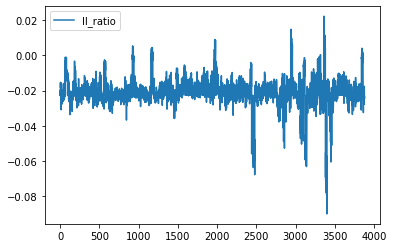

In [13]:
#Plot ratio as is

delta_df.plot(y='ll_ratio')

In [14]:
#Split > off of mutation
N501Y_df['mutation'] = N501Y_df['mutation'].map(lambda x: x.lstrip('>'))
mutants_df['mutation'] = mutants_df['mutation'].map(lambda x: x.lstrip('>'))
delta_df['mutation'] = delta_df['mutation'].map(lambda x: x.lstrip('>'))

#Copy mutation to column index

N501Y_df['index']=N501Y_df['mutation']
mutants_df['index']=mutants_df['mutation']
delta_df['index']=delta_df['mutation']

#Remove wild type sequence (first one)

N501Y_df_noWT = N501Y_df.copy()
N501Y_df_noWT = N501Y_df_noWT.iloc[1: , :]

mutants_df_noWT = mutants_df.copy()
mutants_df_noWT = mutants_df_noWT.iloc[1: , :]

delta_df_noWT = delta_df.copy()
delta_df_noWT = delta_df_noWT.iloc[1: , :]

#Remove index from mutation column, and amino acid from index column.
#This gives us one column defining index & one column defining the amino acid at that position.

N501Y_df_noWT['mutation'] = N501Y_df_noWT['mutation'].str.replace('\d+', '')
N501Y_df_noWT['index'] = N501Y_df_noWT['index'].str.replace(str(aalist), '')

mutants_df_noWT['mutation'] = mutants_df_noWT['mutation'].str.replace('\d+', '')
mutants_df_noWT['index'] = mutants_df_noWT['index'].str.replace(str(aalist), '')

delta_df_noWT['mutation'] = delta_df_noWT['mutation'].str.replace('\d+', '')
delta_df_noWT['index'] = delta_df_noWT['index'].str.replace(str(aalist), '')

/tmp/ipykernel_902840/100052836.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  N501Y_df_noWT['mutation'] = N501Y_df_noWT['mutation'].str.replace('\d+', '')
/tmp/ipykernel_902840/100052836.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  N501Y_df_noWT['index'] = N501Y_df_noWT['index'].str.replace(str(aalist), '')
/tmp/ipykernel_902840/100052836.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  mutants_df_noWT['mutation'] = mutants_df_noWT['mutation'].str.replace('\d+', '')
/tmp/ipykernel_902840/100052836.py:30: FutureWarning: The default value of regex will change from True to False in a future version.
  mutants_df_noWT['index'] = mutants_df_noWT['index'].str.replace(str(aalist), '')
/tmp/ipykernel_902840/100052836.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  delta_df_

In [15]:
#Shift index to true index; i.e. change position 0 to position 333 for RBD.

true_index = 333

N501Y_df_noWT['index'] = pd.to_numeric(N501Y_df_noWT['index'])
N501Y_df_noWT['index'] = N501Y_df_noWT['index'] + true_index

delta_df_noWT['index'] = pd.to_numeric(delta_df_noWT['index'])
delta_df_noWT['index'] = delta_df_noWT['index'] + true_index

#result here is a pivot table of ll_ratio, other pivot tables are of just likelihood

result = delta_df_noWT.pivot_table(index='mutation', columns='index', values='ll_ratio',sort=False)

mutants_df_noWT['index'] = pd.to_numeric(mutants_df_noWT['index'])
mutants_df_noWT['index'] = mutants_df_noWT['index'] + true_index

#Create a pivot table w/ index on x and mutation on y

result_mut = mutants_df_noWT.pivot_table(index='mutation', columns='index', values='likelihood',sort=False)

result_N501Y = N501Y_df_noWT.pivot_table(index='mutation', columns='index', values='likelihood',sort=False)

result_delta = delta_df_noWT.pivot_table(index='mutation', columns='index', values='likelihood',sort=False)

In [16]:
#Normalize columns to 1

for column in result_N501Y:
    result_N501Y[column] = result_N501Y[column]/result_N501Y[column].sum()

for column in result_mut:
    result_mut[column] = result_mut[column]/result_mut[column].sum()


In [17]:
#Ship to excel

result_delta.to_excel('data/result_delta.xlsx')

# Comparing Delta and Wuhan

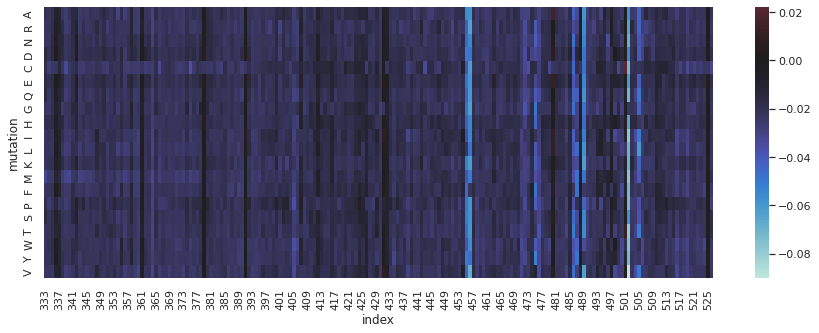

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result, annot=False, cmap='icefire',center=0)
plt.show()

#Heatmap of ll_ratio

In [19]:
#### NA THE 501 POSITION ABOVE

### Ian Wilson group Nat Comm Flu epistasis deep mutational scanning 2020 7 diff flu-HA backgrounds all possible amino acid changes at like 6 sites

### make sure i'm using gpu compute lmao

### Figure out if JSD is using softmax to make it probabilities -> making it jensen shannon

<AxesSubplot:xlabel='index'>

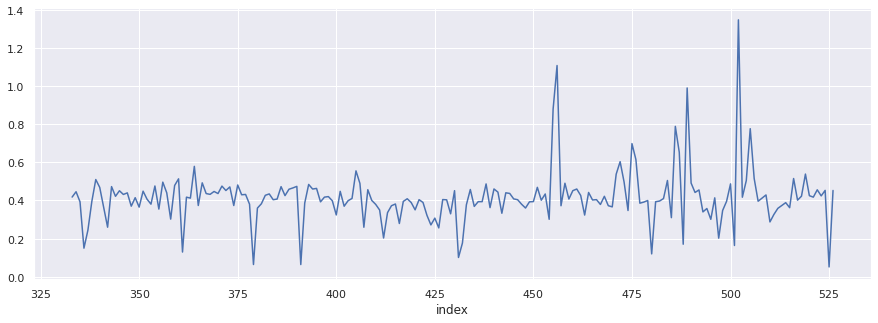

In [20]:
#Quick & dirty quantification - vertical sum of absolute values of heatmap

result_abs = abs(result)
resultsum = result_abs.sum()
resultsum.plot()

# Wuhan/Variants Heatmaps

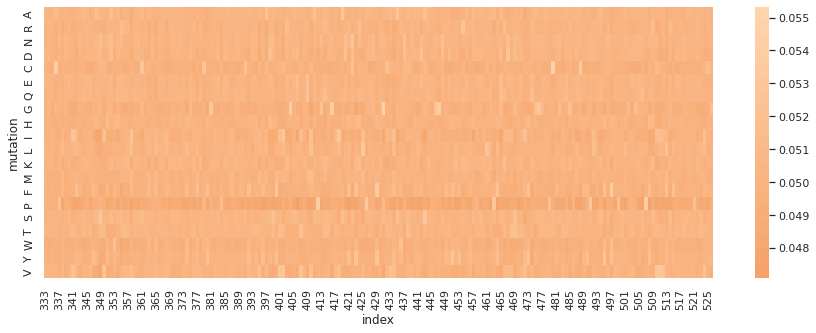

In [21]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_mut, annot=False, cmap='icefire',center=0)
plt.show()
#Wuhan

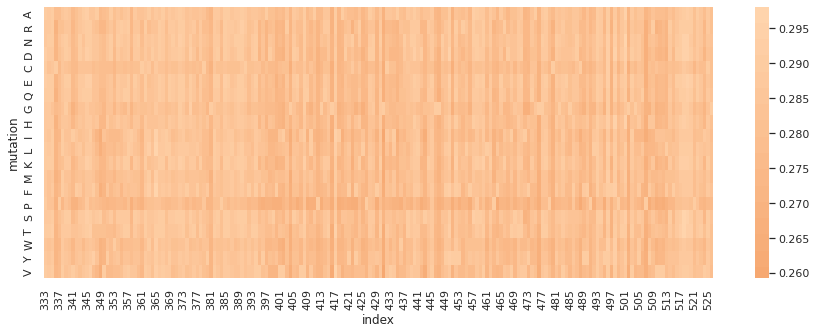

In [22]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_delta, annot=False, cmap='icefire',center=0)
plt.show()
#delta

# Bloom Data

In [23]:
#Let's try a Spearman correlation with the JB expression data.

#First, let's import the data and separate it into dataframes for each variant.

jb_df = pd.read_csv('data/bloom_science_expr.csv')

In [24]:
#create unique list of names
VariantNames = jb_df.target.unique()

#create a data frame dictionary to store the data frames
bloom_data = {elem : pd.DataFrame() for elem in VariantNames}

for key in bloom_data.keys():
    bloom_data[key] = jb_df[:][jb_df.target == key]

In [25]:
#Pivot table to get each variant
bloom_N501Y = bloom_data['N501Y'].pivot_table(index='mutant', columns='position', values='delta_expr',sort=False)
bloom_wuhan = bloom_data['Wuhan-Hu-1'].pivot_table(index='mutant', columns='position', values='delta_expr',sort=False)
bloom_delta = bloom_data['Delta'].pivot_table(index='mutant', columns='position', values='delta_expr',sort=False)

#Drop the first two columns and last five columns; these are cut out in the native sequence for esm-if1.
bloom_N501Y = bloom_N501Y.iloc[: , 2:196]
bloom_wuhan = bloom_wuhan.iloc[: , 2:196]
bloom_delta = bloom_delta.iloc[: , 2:196]


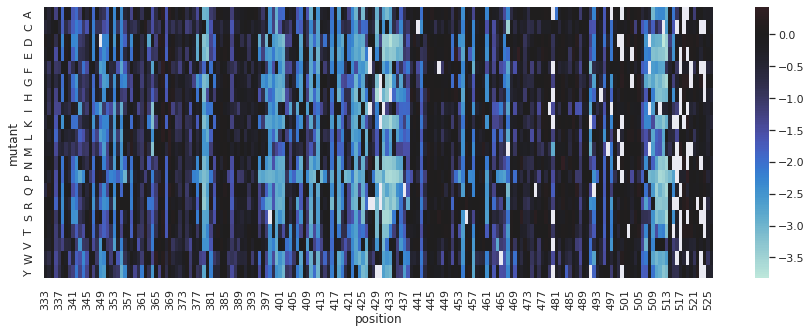

In [26]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(bloom_wuhan, annot=False, cmap='icefire',center=0)
plt.show()
#wuhan

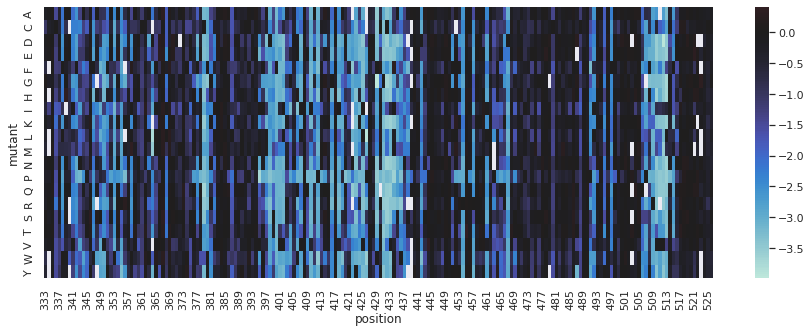

In [27]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(bloom_N501Y, annot=False, cmap='icefire',center=0)
plt.show()
#N501Y

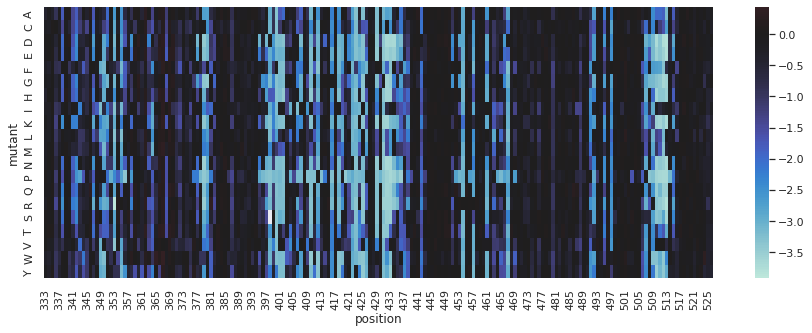

In [28]:
sns.set(rc = {'figure.figsize':(15,5)})

cmaptest = sns.diverging_palette(240, 0, s=100, sep=1 ,l=70, center='dark',as_cmap=True)

sns.heatmap(bloom_delta, annot=False, cmap='icefire',center=0)
plt.show()
#delta

In [29]:
bloom_data

{'Beta':      target wildtype  position mutant mutation     bind  delta_bind  \
 0      Beta        N       331      A    N331A  9.41007     0.10297   
 1      Beta        N       331      C    N331C  9.11229    -0.19481   
 2      Beta        N       331      D    N331D  9.31717     0.01007   
 3      Beta        N       331      E    N331E  9.36899     0.06189   
 4      Beta        N       331      F    N331F  9.17224    -0.13487   
 ...     ...      ...       ...    ...      ...      ...         ...   
 4015   Beta        T       531      S    T531S  9.45912     0.15202   
 4016   Beta        T       531      T    T531T  9.30710     0.00000   
 4017   Beta        T       531      V    T531V  9.32850     0.02140   
 4018   Beta        T       531      W    T531W  9.01219    -0.29491   
 4019   Beta        T       531      Y    T531Y  9.33084     0.02374   
 
       n_bc_bind  n_libs_bind  bind_rep1  bind_rep2  bind_rep3      expr  \
 0             6            3    9.31807    9.4996

In [30]:
#Now to actually try a spearman correlation; we need to put all the bloom delta expression and my data in one column each.

delta_df_noWT_rn = delta_df_noWT.copy()
delta_df_noWT_rn = delta_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})

delta_df_noWT_rn = delta_df_noWT.copy()
delta_df_noWT_rn = delta_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})

delta_merged_df = delta_df_noWT_rn.merge(bloom_data['Delta'],on = ['position', 'mutant'], how = 'left')

In [31]:
#Now the actual spearman correlation


corr_columns_delta = delta_merged_df[['likelihood','expr']]


N501Y expression correlation

Delta expression correlation

In [32]:
corr_columns_delta.corr(method='spearman')

,likelihood,expr
likelihood,1.000000,0.609472
expr,0.609472,1.000000


<AxesSubplot:xlabel='likelihood'>

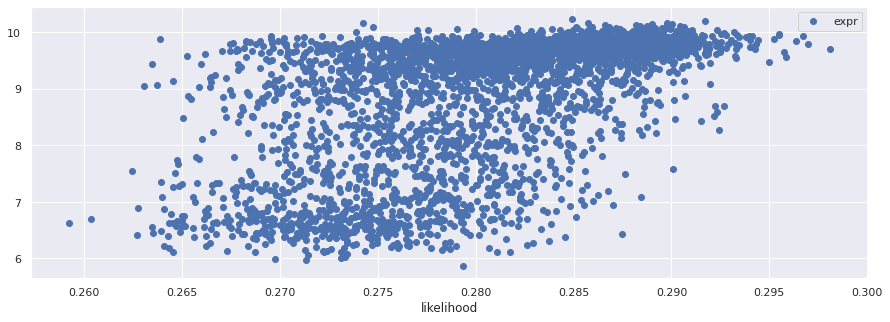

In [33]:
corr_columns_delta.plot(x='likelihood',y='expr',style='o')

Correlation for binding

In [34]:
corr_columns_delta_bind = delta_merged_df[['likelihood','bind']]
corr_columns_delta_bind.corr(method='spearman')

,likelihood,bind
likelihood,1.000000,0.667634
bind,0.667634,1.000000


In [35]:
#Put bloom data as expr_ratio on same metric that we did for ESM outputs

bloom_data_delta_expr = bloom_data['Delta'][['position','mutant','expr']]
bloom_data_delta_expr['expr_ratio'] = np.log(bloom_data['Delta']['expr'].to_numpy()/10.14430) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)


/tmp/ipykernel_902840/820061357.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bloom_data_delta_expr['expr_ratio'] = np.log(bloom_data['Delta']['expr'].to_numpy()/10.14430) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)


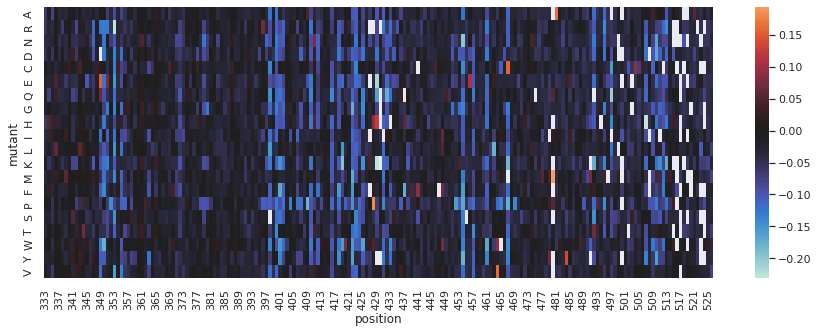

In [36]:
#Actual comparison for delta with same metric

delta_merged_df_2 = delta_df_noWT_rn.merge(bloom_data_delta_expr,on = ['position', 'mutant'], how = 'left')


bloom_pivot_delta = delta_merged_df_2.pivot_table(index='mutant', columns='position', values='expr_ratio',sort=False)

sns.heatmap(bloom_pivot_delta, annot=False, cmap='icefire',center=0)
plt.show()


<AxesSubplot:xlabel='position'>

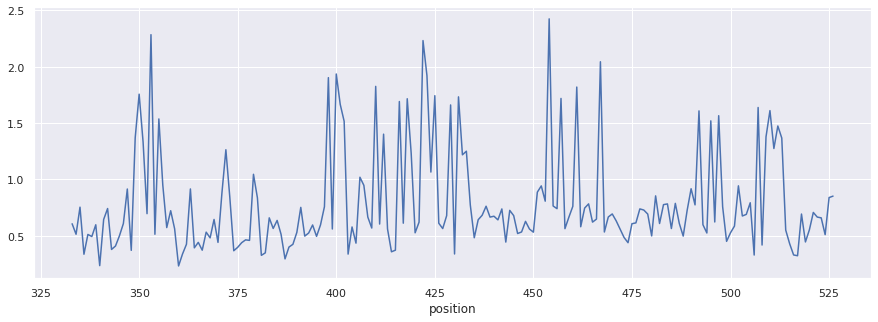

In [37]:
#Vertical sum for bloom data delta comparison
bloom_pivot_delta_abs = abs(bloom_pivot_delta)
bloom_pivot_delta_sum = bloom_pivot_delta_abs.sum()
bloom_pivot_delta_sum.plot()

In [38]:
delta_df_noWT_rn = delta_df_noWT.copy()
delta_df_noWT_rn = delta_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})
delta_merged_df = delta_df_noWT_rn.merge(bloom_data_delta_expr,on = ['position', 'mutant'], how = 'left')

Correlating the epistatic shifts w/ both operated on the same way.

In [39]:
corr_columns_delta_expr_ratio.plot(x='ll_ratio',y='expr_ratio',style='o')

NameError: name 'corr_columns_delta_expr_ratio' is not defined

Jensen-shannon divergence

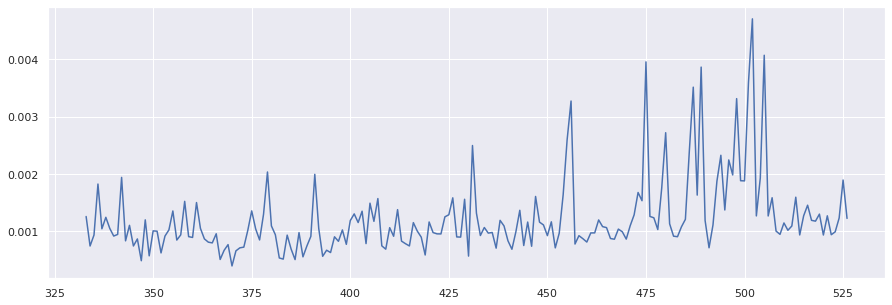

In [40]:
#Cycle through all positions, calculate JSD between results_delta and result_mutant at each position
import scipy

jsd_delta = []
columns=[]

for column in result_delta:
    columns.append(column)
    jsd_delta.append(scipy.spatial.distance.jensenshannon(result_delta[column],result_mut[column]))
    
plt.plot(columns,jsd_delta)

In [41]:
result_delta

index,333,334,335,336,337,338,339,340,341,342,...,517,518,519,520,521,522,523,524,525,526
mutation,,,,,,,,,,,,,,,,,,,,,
A,0.290548,0.286492,0.290083,0.278840,0.279188,0.284703,0.287263,0.285761,0.276708,0.281725,...,0.287304,0.290300,0.293352,0.289264,0.280428,0.289264,0.284807,0.277216,0.286915,0.281426
R,0.288448,0.288370,0.289744,0.269603,0.279590,0.281594,0.286103,0.285533,0.273935,0.279451,...,0.290114,0.290769,0.289808,0.288964,0.279621,0.288549,0.285624,0.273926,0.288266,0.280632
N,0.287735,0.289264,0.289102,0.271626,0.281934,0.286431,0.291004,0.286075,0.276289,0.281274,...,0.290980,0.294961,0.293465,0.288490,0.280828,0.288424,0.284965,0.276214,0.285754,0.283653
D,0.291350,0.288321,0.288604,0.271589,0.279504,0.284711,0.291033,0.287977,0.276887,0.278950,...,0.290962,0.295495,0.294324,0.288682,0.282100,0.288020,0.283904,0.272368,0.283421,0.280111
C,0.289257,0.282787,0.285212,0.289264,0.274935,0.284475,0.282224,0.280777,0.274987,0.276728,...,0.283036,0.287623,0.284941,0.282985,0.273919,0.283449,0.278177,0.278154,0.289264,0.281395
E,0.291863,0.289391,0.290009,0.271457,0.278539,0.285512,0.289122,0.289264,0.277088,0.280632,...,0.290645,0.292490,0.293465,0.291725,0.283196,0.289842,0.285719,0.275948,0.285649,0.280542
Q,0.290335,0.288922,0.289255,0.270000,0.279037,0.285578,0.287449,0.287415,0.275713,0.278846,...,0.290196,0.290851,0.291763,0.290731,0.281230,0.288890,0.285546,0.276975,0.287145,0.282027
G,0.288573,0.288538,0.284005,0.274883,0.277940,0.281956,0.289264,0.280544,0.269023,0.274897,...,0.283876,0.290109,0.290493,0.284412,0.276087,0.280606,0.277850,0.271801,0.283031,0.289264
H,0.288294,0.286686,0.287250,0.269720,0.277989,0.284924,0.286170,0.282380,0.274774,0.279456,...,0.289500,0.291597,0.289264,0.287530,0.279837,0.285657,0.281251,0.273511,0.286623,0.280908


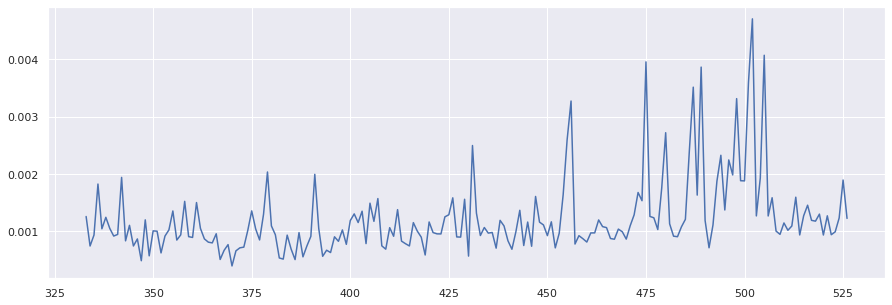

In [42]:
plt.plot(columns,jsd_delta)

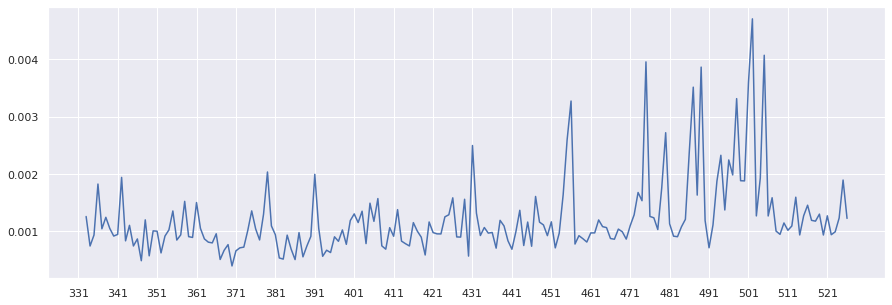

In [43]:
#Cycle through all positions, calculate JSD between results_delta and result_mutant at each position

#This time did absolute values of each vector.

#You want JSD between pairs of columns.

import scipy

jsd_delta = []
columns = []

for column in result_delta:
    columns.append(column)
    jsd_delta.append(scipy.spatial.distance.jensenshannon(result_delta[column],result_mut[column]))
    
plt.plot(columns,scipy.spatial.distance.jensenshannon(abs(result_delta),abs(result_mut),axis=0))

freq_x = 10

plt.xticks(np.arange(331, 531, freq_x))
plt.show()

In [44]:
bloom_data['Delta']

,target,wildtype,position,mutant,mutation,bind,delta_bind,n_bc_bind,n_libs_bind,bind_rep1,bind_rep2,bind_rep3,expr,delta_expr,n_bc_expr,n_libs_expr,expr_rep1,expr_rep2
16080,Delta,N,331,A,N331A,9.11303,0.07778,15,2,9.05540,9.17065,NaN,9.89491,0.10465,17,2,9.83185,9.95797
16081,Delta,N,331,C,N331C,8.93456,-0.10069,33,2,8.93041,8.93870,NaN,9.48209,-0.30817,34,2,9.57902,9.38517
16082,Delta,N,331,D,N331D,8.91193,-0.12331,28,2,9.03746,8.78640,NaN,9.70582,-0.08444,29,2,9.76011,9.65154
16083,Delta,N,331,E,N331E,9.09037,0.05512,34,2,9.07868,9.10205,NaN,9.83692,0.04665,35,2,9.90009,9.77375
16084,Delta,N,331,F,N331F,8.97701,-0.05824,28,2,8.98825,8.96576,NaN,9.54887,-0.24139,29,2,9.39284,9.70490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20095,Delta,T,531,S,T531S,9.03510,-0.00015,24,2,9.00314,9.06706,NaN,9.81783,0.02757,25,2,9.81554,9.82012
20096,Delta,T,531,T,T531T,9.03525,0.00000,36189,2,9.00711,9.06338,NaN,9.79026,0.00000,37693,2,9.75058,9.82995
20097,Delta,T,531,V,T531V,9.07490,0.03965,27,2,9.07401,9.07580,NaN,9.70583,-0.08443,27,2,9.61395,9.79772
20098,Delta,T,531,W,T531W,9.06536,0.03012,24,2,9.01741,9.11332,NaN,9.77484,-0.01542,26,2,9.84511,9.70457


In [45]:
#Importing binding and expression JSD from Bloom data as dataframes

binding_jsd_url = 'https://raw.githubusercontent.com/jbloomlab/SARS-CoV-2-RBD_DMS_variants/main/results/epistatic_shifts/JSD_versus_Wuhan1_by_target.csv'
expression_jsd_url = 'https://raw.githubusercontent.com/jbloomlab/SARS-CoV-2-RBD_DMS_variants/main/results/epistatic_shifts/JSD_versus_Wuhan1_EXPRESSION_by_target.csv'

binding_jsd_df = pd.read_csv(binding_jsd_url)
expression_jsd_df = pd.read_csv(expression_jsd_url)



In [46]:
#Selecting just delta binding + those that bind > 1 stdev above mean (top ~7%)

binding_jsd_df_delta = binding_jsd_df.loc[(binding_jsd_df['bg_1'] == 'Wuhan-Hu-1') & (binding_jsd_df['bg_2'] == 'delta')]
mean_delta = binding_jsd_df_delta['JSD'].mean()
sd_delta = binding_jsd_df_delta['JSD'].std()


top_delta_bind_df = binding_jsd_df_delta[((binding_jsd_df_delta['JSD'] > mean_delta+sd_delta))]

top_delta_bind_df

,bg_1,bg_2,site,JSD,JSD_min3bc,JSD_min5bc


In [47]:
#Selecting just delta expression + those that express > 1 stdev above mean (top ~12%)

expression_jsd_df_delta = expression_jsd_df.loc[(expression_jsd_df['bg_1'] == 'Wuhan-Hu-1') & (expression_jsd_df['bg_2'] == 'Delta')]
mean_delta_exp = expression_jsd_df_delta['JSD'].mean()
sd_delta_exp = expression_jsd_df_delta['JSD'].std()

expression_jsd_df_delta

,bg_1,bg_2,site,JSD,JSD_min3bc,JSD_min5bc
603,Wuhan-Hu-1,Delta,331,0.018557,0.022638,0.022638
604,Wuhan-Hu-1,Delta,332,0.017015,0.016108,0.016108
605,Wuhan-Hu-1,Delta,333,0.024489,0.015190,0.015190
606,Wuhan-Hu-1,Delta,334,0.044837,0.044837,0.044837
607,Wuhan-Hu-1,Delta,335,0.013597,0.013597,0.013597
...,...,...,...,...,...,...
799,Wuhan-Hu-1,Delta,527,0.029747,0.024491,0.024491
800,Wuhan-Hu-1,Delta,528,0.009055,0.009055,0.009055
801,Wuhan-Hu-1,Delta,529,0.024397,0.017454,0.017454
802,Wuhan-Hu-1,Delta,530,0.026764,0.027200,0.023340


In [49]:
#Repeat for the calculated absolute value JSDs from LM data

jsd_abs = scipy.spatial.distance.jensenshannon(abs(result_delta),abs(result_mut))
jsd_notabs = scipy.spatial.distance.jensenshannon(result_delta,result_mut)
jsd_notabs_df = pd.DataFrame(jsd_notabs)
jsd_notabs_df['Index']=columns

jsd_abs_df = pd.DataFrame(jsd_abs)
jsd_abs_df['Index']=columns

mean_jsd_abs = jsd_abs_df[0].mean()
sd_jsd_abs = jsd_abs_df[0].std()

top_abs_jsd_df = jsd_abs_df[((jsd_abs_df[0] > mean_jsd_abs+sd_jsd_abs))]

top_abs_jsd_df

,0,Index
9,0.001937,342
46,0.002032,379
58,0.001991,391
98,0.002495,431
122,0.002592,455
123,0.003272,456
142,0.003957,475
147,0.002718,480
153,0.002395,486
154,0.003515,487


Now to do Spearman's rank correlation between JSD from language model (jsd_notabs_df) and JSD from Bloom data (expression_jsf_df_N501Y

In [50]:
#Counting matches between expression & log likelihoods

count = 0

for i in top_abs_jsd_df['Index']:
    if (i in set(top_delta_expr_df['site'])):
        count +=1
    #elif (i+1 in set(top_delta_expr_df['site'])):
     #   count +=1
    #elif (i-1 in set(top_delta_expr_df['site'])):
     #   count +=1

print('number of matches:')
print(count)
print('fraction of top sites found:')
print(count/len(top_delta_expr_df))
print('fraction of predicted sites that are top sites:')
print(count/len(top_abs_jsd_df))

NameError: name 'top_delta_expr_df' is not defined

In [ ]:
#Counting matches between binding & log likelihood jsd

count = 0

for i in top_abs_jsd_df['Index']:
    if (i in set(top_delta_bind_df['site'])):
        count +=1
    #elif (i+1 in set(top_delta_bind_df['site'])):
     #   count +=1
    #elif (i-1 in set(top_delta_bind_df['site'])):
     #   count +=1

print('number of matches:')
print(count)
print('fraction of top sites found:')
print(count/len(top_delta_bind_df))
print('fraction of predicted sites that are top sites:')
print(count/len(top_abs_jsd_df))

In [51]:
#Just simplify the expression dataframe to what i need here
jsd_delta = expression_jsd_df_delta[['site','JSD']].copy()


In [52]:
#rename
jsd_notabs_df.columns = {'site' if x=='Index' else x for x in jsd_notabs_df.columns}

In [53]:
#renaming columns & merging dfs to one dataframe with site, LM jsd, and Bloom jsd
combined_jsd_df = pd.merge(jsd_notabs_df, jsd_delta, on='site')
combined_jsd_df.columns = {'JSD_LM' if x==0 else x for x in combined_jsd_df.columns}
combined_jsd_df.columns = {'JSD_delta' if x=='site' else x for x in combined_jsd_df.columns}
combined_jsd_df.columns = {'Index' if x=='JSD_LM' else x for x in combined_jsd_df.columns}

In [54]:
combined_jsd_df

,JSD_delta,JSD,Index
0,0.001254,333,0.024489
1,0.000738,334,0.044837
2,0.000930,335,0.013597
3,0.001821,336,0.034151
4,0.001039,337,0.011934
...,...,...,...
189,0.000935,522,0.016579
190,0.000986,523,0.031717
191,0.001227,524,0.041401
192,0.001891,525,0.011963


In [55]:
#spearman correlation pt1
combined_jsd_df.corr(method='spearman')

scipy.stats.spearmanr(combined_jsd_df['Index'],combined_jsd_df['JSD_delta'])

SpearmanrResult(correlation=0.06372607632156789, pvalue=0.37736428508930187)

<AxesSubplot:>

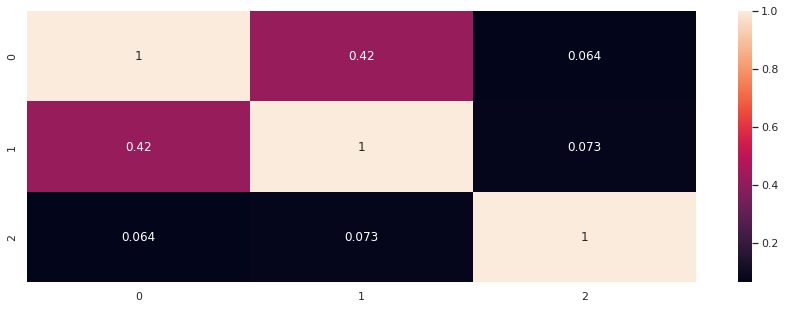

In [56]:
#spearman correlation attempt 2
corr_jsd,pval_corr_jsd = scipy.stats.spearmanr(jsd_notabs_df,jsd_delta[2:196]['JSD'])
sns.heatmap(corr_jsd, annot = True)


In [57]:
#Manually doing Spearman correlation to check lol

combined_jsd_df_ranks = combined_jsd_df.rank()
combined_jsd_df['JSD_rank'] = combined_jsd_df_ranks['Index']
combined_jsd_df['JSD_delta_rank'] = combined_jsd_df_ranks['JSD_delta']
combined_jsd_df['d'] = combined_jsd_df['JSD_rank']-combined_jsd_df['JSD_delta_rank']
combined_jsd_df['d^2'] = combined_jsd_df['d']**2

rho = 1 - (6*(combined_jsd_df['d^2'].sum())/(len(combined_jsd_df)*(((len(combined_jsd_df))**2)-1)))
print(rho)
combined_jsd_df

0.06372646102895552


,JSD_delta,JSD,Index,JSD_rank,JSD_delta_rank,d,d^2
0,0.001254,333,0.024489,140.0,138.0,2.0,4.0
1,0.000738,334,0.044837,186.0,26.0,160.0,25600.0
2,0.000930,335,0.013597,63.0,68.0,-5.0,25.0
3,0.001821,336,0.034151,174.0,171.0,3.0,9.0
4,0.001039,337,0.011934,53.0,100.0,-47.0,2209.0
...,...,...,...,...,...,...,...
189,0.000935,522,0.016579,86.0,73.0,13.0,169.0
190,0.000986,523,0.031717,163.0,87.0,76.0,5776.0
191,0.001227,524,0.041401,184.0,134.0,50.0,2500.0
192,0.001891,525,0.011963,54.0,175.0,-121.0,14641.0
